# After Filters

For analyzing which and how many hits are left after running each of the RFI filters

#### Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import os
from datetime import datetime, timedelta
import multiprocessing

ImportError: cannot import name 'csr_array' from 'scipy.sparse' (/home/nstiegle/miniforge3/envs/stamp_viewer/lib/python3.7/site-packages/scipy/sparse/__init__.py)

In [2]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    data_path = "/datax/scratch/nstieg/"
elif hostname == "cosmic-gpu-1":
    data_path = "/mnt/cosmic-gpu-1/data0/nstiegle/"
else:
    raise Exception("Data path not known")

full_dataset_path = data_path + "25GHz_higher.pkl"
coherent_dataset_path = data_path + "25GHz_higher_coherent.pkl"
incoherent_dataset_path = data_path + "25GHz_higher_incoherent.pkl"

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
coherent_full = pd.read_pickle(data_path + "25GHz_higher_coherent_all_columns.pkl")
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

# Describe all the filters
filter_descriptions = [
    "All data",
    "Groups of f of all 0 drift rate",
    "Groups of f of all <.25 drift rate",
    "Groups of f of all <2 drift rate",
    "Groups of f of hits from each source with > 1 hit",
    "Groups of f > 1 hit from all sources",
    "Zero drift rate",
    "SNR < 10",
    "SNR > 100",
    "Within 2hz of another hit",
    "Within 10hz of another hit",
    "Anything not pointing to or pointed by another hit",
    "Low SNR hits from pointings with few integrations"
]

In [3]:
# Take the results of filters (lists of the ids of hits which pass the filter) and turn
# them into datasets to analyze. Only needs to be run if there's a new filter created as
# it saves the datasets to file

# # Setup containers to hold data
# after_filter_dfs = [coherent] # All the dataframes holding hits which passed a certain filer. First dataframe is full dataset
# after_filter_dfs_by_source = [[source for source_name, source in coherent.groupby('source_name')]] # Dataframes above but grouped by source
# after_filter_source_sizes = [[len(source) for source in after_filter_dfs_by_source[-1]]]
# source_names = [source_name for source_name, source in coherent.groupby('source_name')] # Names of sources, in order of grouped dfs above

# # Where the results of filter i are stored (i > 0)
# def get_filter_results_path(i):
#     return f'/home/nstieg/BL-COSMIC-2024-proj/filters/filter{i}/run_filter_{i}_coherent_results.npy'

# # Get results of all filters and store them
# num_filters = 12
# for filter in range(1, num_filters + 1):
#     # Load in results of this filter
#     filter_results_path = get_filter_results_path(filter)
#     filter_results = np.load(filter_results_path)

#     # Get new df with just hits which are results of this filter
#     prev_df = after_filter_dfs[filter - 1].copy()
#     ids_in_both = list(set(prev_df.id).intersection(filter_results))
#     prev_df = prev_df.set_index('id')
#     next_df = prev_df.loc[ids_in_both].reset_index()

#     # Save results of this filter to disk so they can be loaded in quickly later
#     filter_name = filter_results_path.split('/')[5]
#     next_df_path = data_path + f"25GHz_higher_coherent_post_{filter_name}.pkl"
#     next_df.to_pickle(next_df_path)

#     # Save results of this filter in container
#     after_filter_dfs.append(next_df)

#     # Save results by group too. Be careful in case a filter removed
#     # all hits in a group (because it won't show up as a group)
#     after_this_filter_dfs_by_source = []
#     groups = after_filter_dfs[-1].groupby('source_name')
#     for source_name in source_names:
#         try:
#             after_this_filter_dfs_by_source.append(groups.get_group(source_name))
#         except KeyError:
#             after_this_filter_dfs_by_source.append([])
#     after_filter_dfs_by_source.append(after_this_filter_dfs_by_source)

#     # Save how many hits were in each source
#     after_filter_source_sizes.append([len(source) for source in after_filter_dfs_by_source[-1]])
    
# after_filter_source_sizes = np.array(after_filter_source_sizes)

In [4]:
# Load in the datasets saved by the above cell containing the
# hits which pass each filter

# Setup containers to hold data
after_filter_dfs = [coherent] # All the dataframes holding hits which passed a certain filer. First dataframe is full dataset
after_filter_dfs_by_source = [[source for source_name, source in coherent.groupby('source_name')]] # Dataframes above but grouped by source
after_filter_source_sizes = [[len(source) for source in after_filter_dfs_by_source[-1]]]
source_names = [source_name for source_name, source in coherent.groupby('source_name')] # Names of sources, in order of grouped dfs above

# Where the results of filter i are stored (i > 0)
def get_filter_results_path(i):
    return f'/home/nstieg/BL-COSMIC-2024-proj/filters/filter{i}/run_filter_{i}_coherent_results.npy'

# Load results of all filters
num_filters = 12
for filter in range(1, num_filters + 1):
    # Figure out where df is saved
    filter_results_path = get_filter_results_path(filter)
    filter_name = filter_results_path.split('/')[5]
    filter_df_path = data_path + f"25GHz_higher_coherent_post_{filter_name}.pkl"

    # Load df
    filter_df = pd.read_pickle(filter_df_path)
    after_filter_dfs.append(filter_df)
    
    # Save results by group too. Be careful in case a filter removed
    # all hits in a group (because it won't show up as a group)
    after_this_filter_dfs_by_source = []
    groups = after_filter_dfs[-1].groupby('source_name')
    for source_name in source_names:
        try:
            after_this_filter_dfs_by_source.append(groups.get_group(source_name))
        except KeyError:
            after_this_filter_dfs_by_source.append([])
    after_filter_dfs_by_source.append(after_this_filter_dfs_by_source)

    # Save how many hits were in each source
    after_filter_source_sizes.append([len(source) for source in after_filter_dfs_by_source[-1]])
    
after_filter_source_sizes = np.array(after_filter_source_sizes)

#### Text Analysis

Looking at the results of the filters in text (statistics)

In [5]:
make_graphs = False

# Print results for each filter
num_filters = 12
for filter in range(1, num_filters + 1):
    # Print delimiter
    print("-"*30 + f"Filter {filter}" + "-"*30)
    
    # Print general statistics of filter
    num_coh = len(coherent)
    num_left = after_filter_source_sizes[filter].sum()
    num_before = after_filter_source_sizes[filter - 1].sum()
    print(f"{num_left} out of {num_before} passed: {round(num_left / num_before * 100, 3)}% ({round(num_left / num_coh * 100, 3)}% of coherent)")

    # Print statistics by group
    for i, source_name in enumerate(source_names):
        n_coh = after_filter_source_sizes[0][i]
        n_before = after_filter_source_sizes[filter - 1][i]
        n_after = after_filter_source_sizes[filter][i]
        print(f"Source {source_name}: {n_before - n_after} were cut ({round((n_before - n_after) * 100 / n_before, 3)}%). Now there are {n_after}/{n_before} ({round(n_after*100/n_before, 3)}%). [{n_after}/{n_coh} ({round(n_after*100/n_coh, 3)}%)]")

    print(f"Total: {num_before - num_left} were cut ({round((num_before - num_left) * 100 / num_before, 3)}%). Now there are {num_left}/{num_before} ({round(num_left*100/num_before, 3)})%")

    if make_graphs:
        # Make Bar Chart
        x = np.arange(len(source_names))  # the label locations
        width = 0.35  # the width of the bars

        # Plotting the data
        fig, ax = plt.subplots(figsize=(6, 8))

        # Bar for "Before"
        rects1 = ax.bar(x - width/2, after_filter_source_sizes[filter - 1], width, label='Before', color='skyblue')

        # Bar for "After"
        rects2 = ax.bar(x + width/2, after_filter_source_sizes[filter], width, label='After', color='salmon')

        # Adding labels, title, and legend
        ax.set_xlabel('Source')
        ax.set_ylabel('Number of Hits')
        ax.set_title(f'Hits Before and After Filter {filter} - {round((num_left) * 100 / num_before, 3)}% left')
        ax.set_xticks(x)
        ax.set_xticklabels(source_names, rotation=90)
        ax.legend()

        # Adding value labels on top of the bars
        def add_labels(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', rotation=90)

        add_labels(rects1)
        add_labels(rects2)

        # Display the plot
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

------------------------------Filter 1------------------------------
2701479 out of 2984740 passed: 90.51% (90.51% of coherent)
Source 2535280716217508992: 23840 were cut (46.335%). Now there are 27611/51451 (53.665%). [27611/51451 (53.665%)]
Source 2536546185381558272: 37329 were cut (43.809%). Now there are 47880/85209 (56.191%). [47880/85209 (56.191%)]
Source 2542485953354555264: 18782 were cut (5.012%). Now there are 355993/374775 (94.988%). [355993/374775 (94.988%)]
Source 2557518579407455104: 27489 were cut (41.812%). Now there are 38256/65745 (58.188%). [38256/65745 (58.188%)]
Source 2646431411821304960: 40108 were cut (2.039%). Now there are 1927195/1967303 (97.961%). [1927195/1967303 (97.961%)]
Source 3073619025268414208: 27497 were cut (17.288%). Now there are 131552/159049 (82.712%). [131552/159049 (82.712%)]
Source 3074407546904630144: 40833 were cut (35.524%). Now there are 74112/114945 (64.476%). [74112/114945 (64.476%)]
Source 3079227054261900160: 31314 were cut (41.9%).

In [138]:
# Look at how many hits per timestamp there were for each of the sources
filter = 0
for i, group in enumerate(after_filter_dfs_by_source[filter]):
    num_timestamps = len(group.tstart.unique())
    source_name = source_names[i]
    num_hits = after_filter_source_sizes[filter][i]
    print(f"{source_name}: {num_hits} hits from {num_timestamps} times ({round(num_hits / num_timestamps, 3)} hits per time)")

2535280716217508992: 51451 hits from 27 times (1905.593 hits per time)
2536546185381558272: 85209 hits from 45 times (1893.533 hits per time)
2542485953354555264: 374775 hits from 77 times (4867.208 hits per time)
2557518579407455104: 65745 hits from 33 times (1992.273 hits per time)
2646431411821304960: 1967303 hits from 134 times (14681.366 hits per time)
3073619025268414208: 159049 hits from 101 times (1574.743 hits per time)
3074407546904630144: 114945 hits from 112 times (1026.295 hits per time)
3079227054261900160: 74735 hits from 39 times (1916.282 hits per time)
3113482167231459200: 4983 hits from 8 times (622.875 hits per time)
3113490855946843904: 5043 hits from 8 times (630.375 hits per time)
3113491272562268160: 5079 hits from 8 times (634.875 hits per time)
3113493127988068096: 4998 hits from 8 times (624.75 hits per time)
3127348761205770496: 71425 hits from 53 times (1347.642 hits per time)


#### Graph Analysis

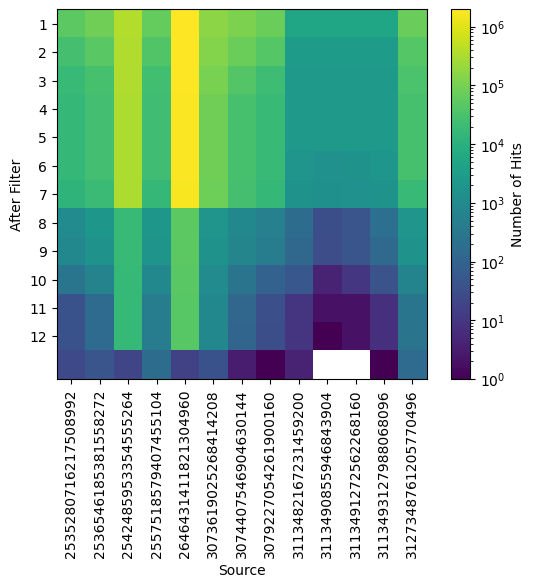

In [179]:
from matplotlib.colors import LogNorm
plt.imshow(after_filter_source_sizes, norm=LogNorm())
cbar = plt.colorbar(label="Number of Hits")
plt.xlabel("Source")
plt.ylabel("After Filter")
plt.xticks(ticks=np.arange(len(source_names)), labels=source_names, rotation=90)
plt.yticks(ticks=np.arange(12), labels=range(1, 12 + 1))
plt.show()

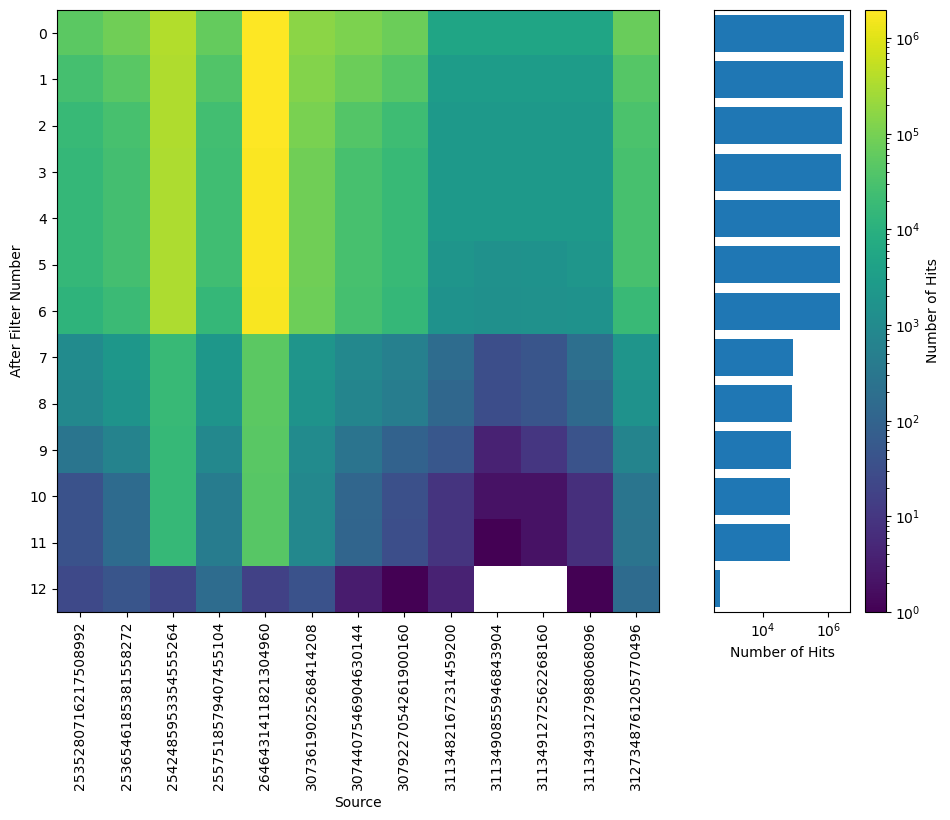

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios': [10, 2, 0.3]}, figsize=(10, 8))

# Plot the heatmap on the first subplot
heatmap = ax[0].imshow(after_filter_source_sizes, cmap='viridis', norm=LogNorm())

# Set xticks and labels for the heatmap
ax[0].set_xticks(np.arange(len(source_names)))
ax[0].set_xticklabels(source_names, rotation=90)
ax[0].set_xlabel("Source")

# Set yticks for the heatmap to align with the rows
row_sums = after_filter_source_sizes.sum(axis=1)
ax[0].set_yticks(np.arange(len(row_sums)))
ax[0].set_ylabel("After Filter Number")

# Plot the bar chart on the second subplot
ax[1].barh(np.arange(len(row_sums)), row_sums[::-1], align='center')
ax[1].set_xscale('log')
ax[1].set_xlabel("Number of Hits")

# Remove yticks on the bar chart to avoid double labeling
ax[1].set_yticks([])
# Align the y-axis of the bar chart with the heatmap
ax[1].set_ylim(-0.5, len(row_sums) - 0.5)

# Put on the colorbar
cbar = fig.colorbar(heatmap, cax=ax[2], label="Number of Hits")

# Display the plot
plt.tight_layout()
plt.show()


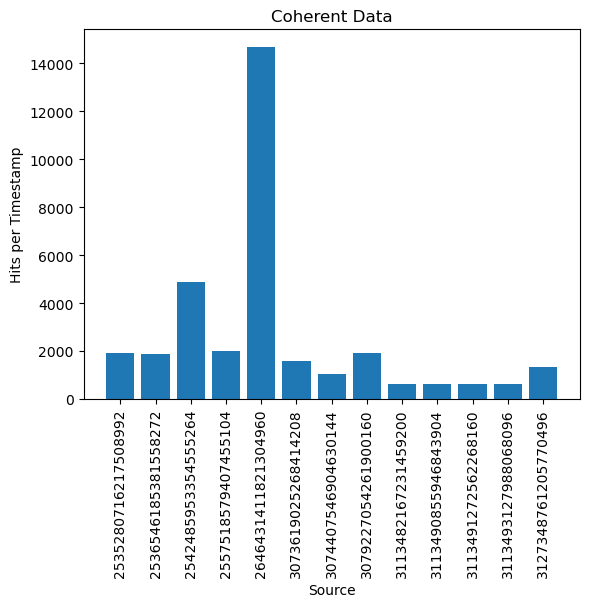

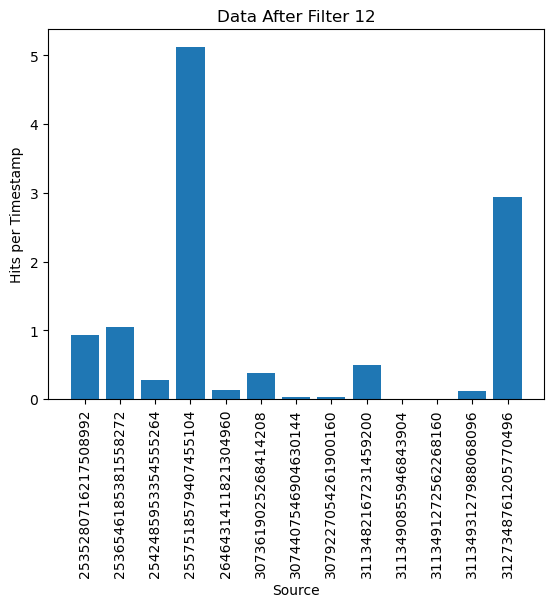

In [181]:
# Look at how many hits per timestamp there were for each of the sources
# for the coherent data
timestamps_per_source = [len(group.tstart.unique()) for group in after_filter_dfs_by_source[0]]
num_hits_per_source = after_filter_source_sizes[0]
plt.bar(range(len(source_names)), np.array(num_hits_per_source) / np.array(timestamps_per_source))
plt.xlabel("Source")
plt.xticks(range(len(source_names)), source_names, rotation=90)
plt.ylabel("Hits per Timestamp")
plt.title("Coherent Data")
plt.show()

# Look at how many hits per timestamp there were for each of the sources
# For after the last filter
timestamps_per_source = [len(group.tstart.unique()) for group in after_filter_dfs_by_source[0]]
num_hits_per_source = after_filter_source_sizes[12]
plt.bar(range(len(source_names)), np.array(num_hits_per_source) / np.array(timestamps_per_source))
plt.xlabel("Source")
plt.xticks(range(len(source_names)), source_names, rotation=90)
plt.ylabel("Hits per Timestamp")
plt.title("Data After Filter 12")
plt.show()

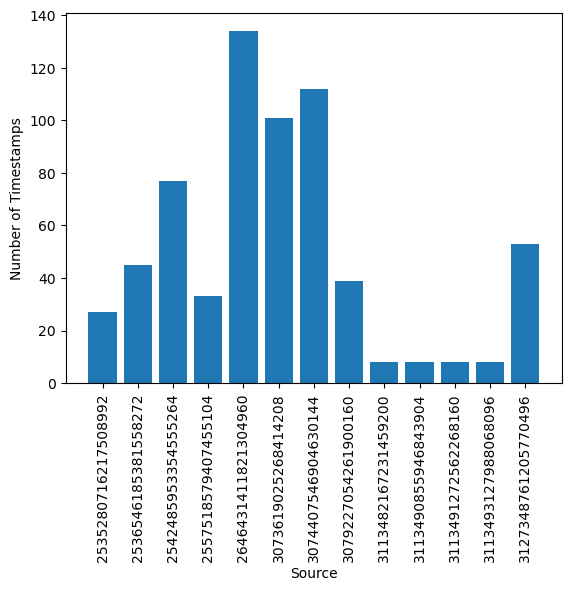

In [142]:
# Look at how many timestamps total were taken for each source
timestamps_per_source = [len(group.tstart.unique()) for group in after_filter_dfs_by_source[0]]
plt.bar(range(len(source_names)), np.array(timestamps_per_source))
plt.xlabel("Source")
plt.xticks(range(len(source_names)), source_names, rotation=90)
plt.ylabel("Number of Timestamps")
plt.show()

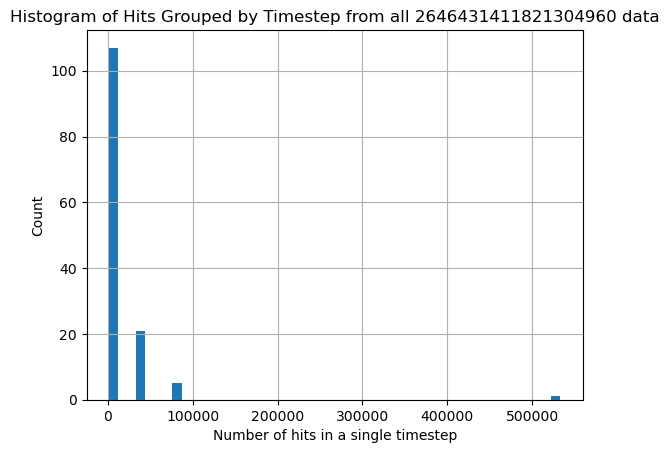

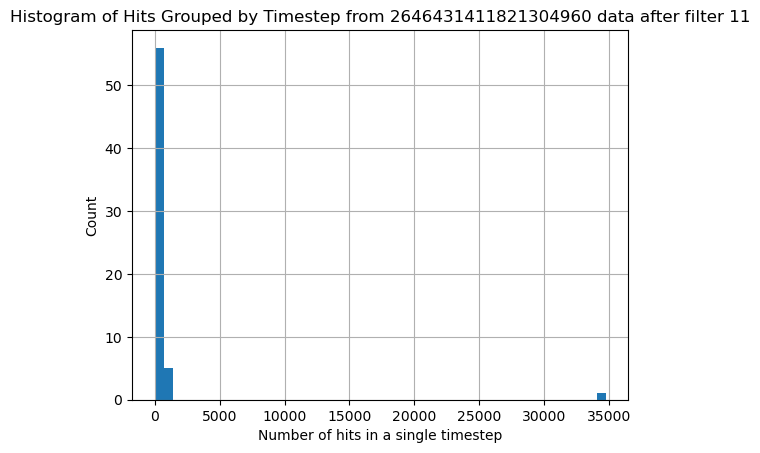

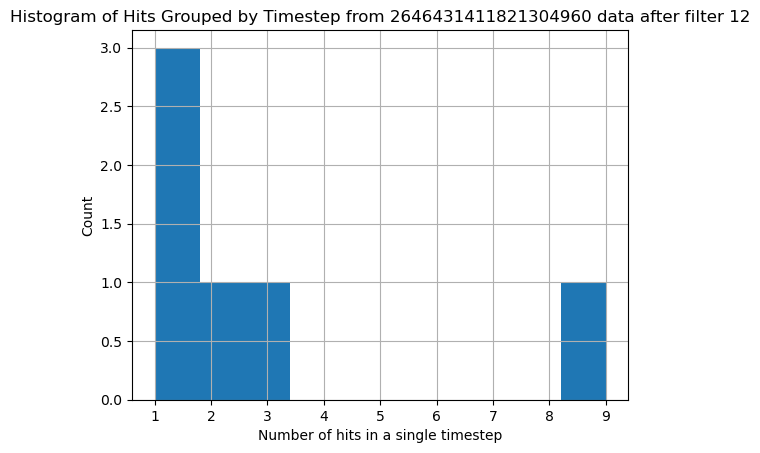

In [183]:
# Look at the group with the big spike
group = after_filter_dfs_by_source[0][4]
time_groups = group.groupby('tstart')
time_groups.size().hist(bins=50)
plt.xlabel("Number of hits in a single timestep")
plt.ylabel("Count")
plt.title(f"Histogram of Hits Grouped by Timestep from all {source_names[4]} data")
plt.show()

# Look at the group with the big spike
group = after_filter_dfs_by_source[11][4]
time_groups = group.groupby('tstart')
time_groups.size().hist(bins=50)
plt.xlabel("Number of hits in a single timestep")
plt.ylabel("Count")
plt.title(f"Histogram of Hits Grouped by Timestep from {source_names[4]} data after filter 11")
plt.show()

# Look at the group with the big spike
group = after_filter_dfs_by_source[12][4]
time_groups = group.groupby('tstart')
time_groups.size().hist()
plt.xlabel("Number of hits in a single timestep")
plt.ylabel("Count")
plt.title(f"Histogram of Hits Grouped by Timestep from {source_names[4]} data after filter 12")
plt.show()

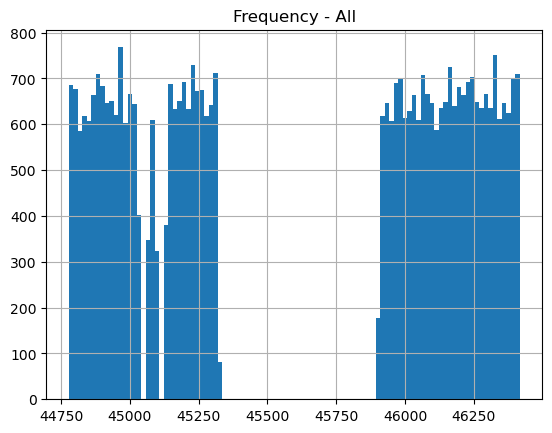

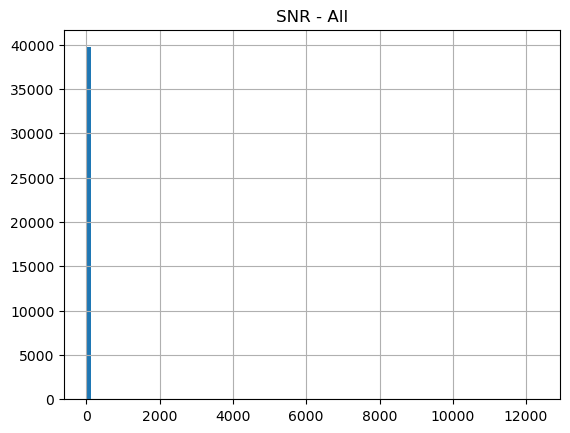

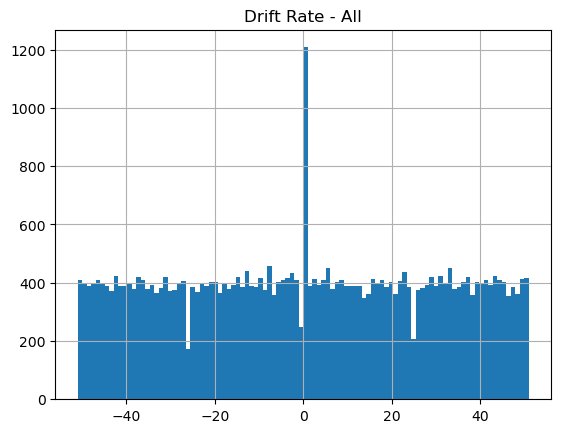

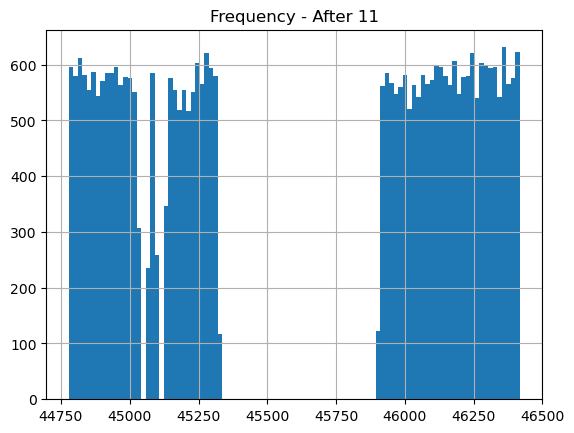

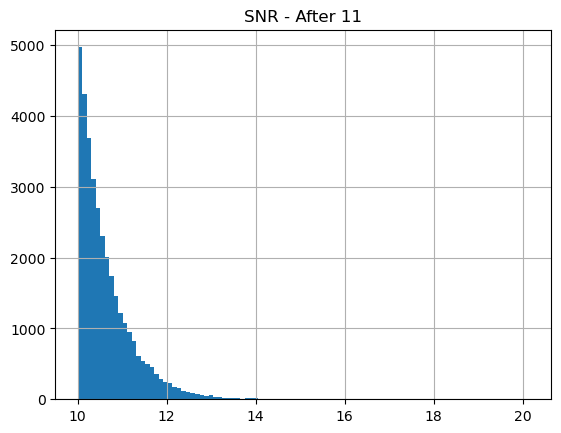

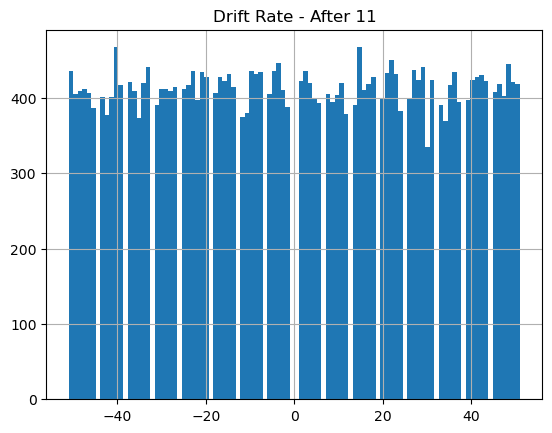

In [184]:
# Look at that biggest group before filters
group = after_filter_dfs_by_source[0][4]
time_groups = group.groupby('tstart')
time_of_biggest_group = time_groups.size().index[(time_groups.size() > 25000)][0]
big_group = time_groups.get_group(time_of_biggest_group)
big_group.signal_frequency.hist(bins=100)
plt.title("Frequency - All")
plt.show()
big_group.signal_snr.hist(bins=100)
plt.title("SNR - All")
plt.show()
big_group.signal_drift_rate.hist(bins=100)
plt.title("Drift Rate - All")
plt.show()

# Look at that biggest group after filter 11
group = after_filter_dfs_by_source[11][4]
time_groups = group.groupby('tstart')
time_of_biggest_group = time_groups.size().index[(time_groups.size() > 25000)][0]
big_group = time_groups.get_group(time_of_biggest_group)
big_group.signal_frequency.hist(bins=100)
plt.title("Frequency - After 11")
plt.show()
big_group.signal_snr.hist(bins=100)
plt.title("SNR - After 11")
plt.show()
big_group.signal_drift_rate.hist(bins=100)
plt.title("Drift Rate - After 11")
plt.show()

In [ ]:
# Let's print out some of the hit indices from this group so I can look
# at stamps
group = after_filter_dfs_by_source[11][4]
time_groups = group.groupby('tstart')
time_of_biggest_group = time_groups.size().index[(time_groups.size() > 25000)][0]
big_group = time_groups.get_group(time_of_biggest_group)
np.array(big_group.id.sample(100)).

array([961506092, 961254996, 961053837, 961332091, 961079661, 961323561,
       961097151, 961500030, 961176195, 961151042, 961133253, 961289454,
       961078204, 961444413, 961257404, 961432596, 961455735, 961367377,
       961202253, 961229876, 961553460, 961234464, 961470650, 961485311,
       961185740, 961443184, 961552931, 961093283, 961340081, 961431727,
       961524002, 961292136, 961222536, 961214565, 961395899, 961222177,
       961353569, 961506302, 961321278, 961032425, 961364738, 961264654,
       961039393, 961516931, 961094705, 961466640, 961272968, 961063310,
       961451153, 961122523, 961113778, 961181067, 961141436, 961440278,
       961496536, 961193426, 961472624, 961368163, 961496158, 961147701,
       961119635, 961031109, 961316007, 961447256, 961170709, 961247585,
       961474995, 961420614, 961530784, 961169600, 961291385, 961490333,
       961553215, 961123050, 961478454, 961318143, 961076614, 961278492,
       961402140, 961487189, 961410843, 961387773, 

In [ ]:
# Look at where this source is on the sky
print("RA:", big_group.ra_hours.unique(), "dec:", big_group.dec_degrees.unique())

RA: [23.7204] dec: [1.35847]


In [ ]:
# Look at how long the integrations were here
# Need data from the full coherent dataset
big_group_full = pd.merge(coherent_full, big_group.id, on='id', how='inner')
print("The big group had only", big_group_full.num_timesteps.unique(), "integrations per viewing")
print("Wow, so the times with shorter integrations seem like they are more likely to get spurious noise being seen as a genuine hit")

The big group had only [4] integrations per viewing
Wow, so the times with shorter integrations seem like they are more likely to get spurious noise being seen as a genuine hit


In [ ]:
# Let's look at what timesteps were used by each source
cf_groups = coherent_full.groupby("source_name")
for name, group in cf_groups:
    print(f"{name}: used {group.num_timesteps.unique()} timesteps and had {round(len(group) * 100 / len(coherent))}% of the hits")
print()
print("So the sources which have most of the hits are the ones which looked with shorter timesteps")

2535280716217508992: used [16] timesteps and had 2% of the hits
2536546185381558272: used [16] timesteps and had 3% of the hits
2542485953354555264: used [16  8  4] timesteps and had 13% of the hits
2557518579407455104: used [16] timesteps and had 2% of the hits
2646431411821304960: used [16  8  4] timesteps and had 66% of the hits
3073619025268414208: used [16  8] timesteps and had 5% of the hits
3074407546904630144: used [16] timesteps and had 4% of the hits
3079227054261900160: used [16] timesteps and had 3% of the hits
3113482167231459200: used [16] timesteps and had 0% of the hits
3113490855946843904: used [16] timesteps and had 0% of the hits
3113491272562268160: used [16] timesteps and had 0% of the hits
3113493127988068096: used [16] timesteps and had 0% of the hits
3127348761205770496: used [16 64] timesteps and had 2% of the hits

So the sources which have most of the hits are the ones which looked with shorter timesteps


In [ ]:
# Just check that each timestep has its own num integrations
for _, group in cf_groups:
    tgroups = group.groupby("tstart")
    for _, group in tgroups:
        assert(len(group.num_timesteps.unique()) == 1)
        assert(len(group.tsamp.unique()) == 1)

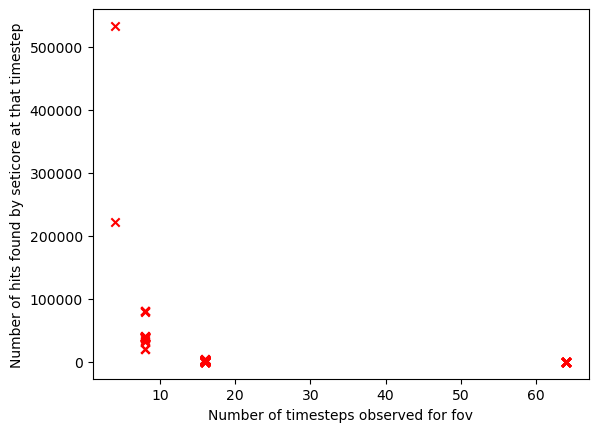

In [ ]:
# Check for correlation beween fewer timesteps and more hits
tgroups = coherent_full.groupby("tstart")
timesteps_used_by_group = [group.num_timesteps.unique() for _, group in tgroups]
num_hits_in_group = [len(group) for _, group in tgroups]
plt.scatter(timesteps_used_by_group, num_hits_in_group, marker='x', color='red')
plt.xlabel("Number of timesteps observed for fov")
plt.ylabel("Number of hits found by seticore at that timestep")
plt.show()

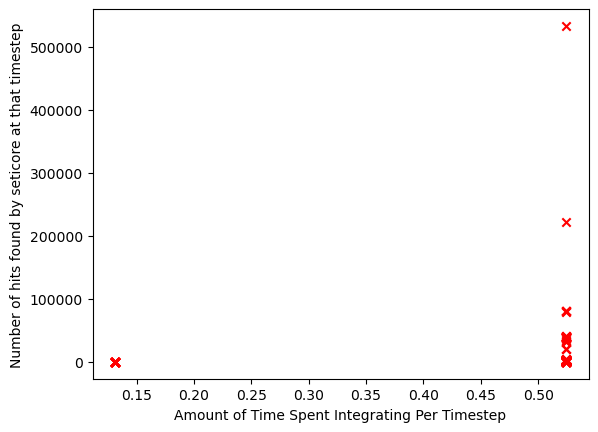

In [ ]:
# See if there's something similar with length of integration
tgroups = coherent_full.groupby("tstart")
time_integrated_by_group = [group.tsamp.unique() for _, group in tgroups]
num_hits_in_group = [len(group) for _, group in tgroups]
plt.scatter(time_integrated_by_group, num_hits_in_group, marker='x', color='red')
plt.xlabel("Amount of Time Spent Integrating Per Timestep")
plt.ylabel("Number of hits found by seticore at that timestep")
plt.show()

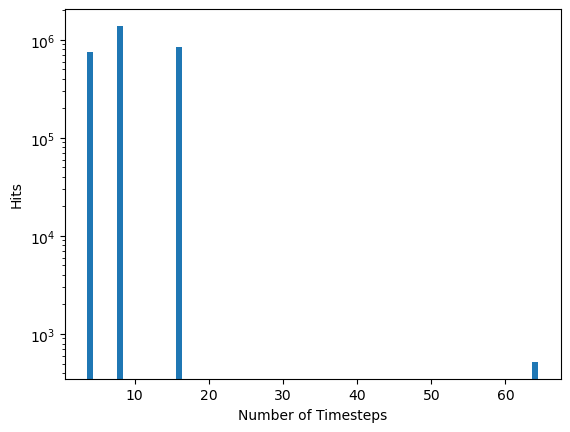

In [6]:
# Try to figure out where the bulk of the hits are coming from
groups = coherent_full.groupby("num_timesteps")
num_timesteps = list(groups.groups.keys())
num_hits_per_num_timesteps_group = np.array([len(group) for _, group in groups])
plt.bar(num_timesteps, num_hits_per_num_timesteps_group)
plt.xlabel("Number of Timesteps")
plt.ylabel("Hits")
plt.yscale('log')
plt.show()

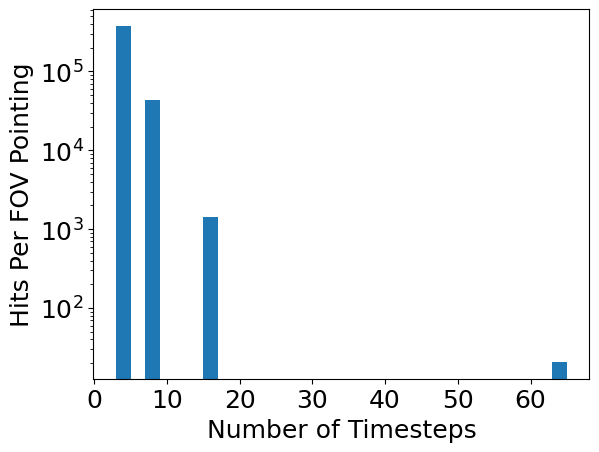

In [9]:
# Look at number of hits per fov for the different num_timesteps
groups = coherent_full.groupby("num_timesteps")

# Get how many FOVs there are for the different groups above
num_fovs_per_num_timestep = []
for _, group in groups:
    fovs = group.groupby('tstart')
    num_fovs_per_num_timestep.append(len(list(fovs.groups.keys())))
num_fovs_per_num_timestep = np.array(num_fovs_per_num_timestep)

# Make plot
plt.bar(num_timesteps, num_hits_per_num_timesteps_group / num_fovs_per_num_timestep, width=2)
plt.xlabel("Number of Timesteps", fontsize=18)
plt.ylabel("Hits Per FOV Pointing", fontsize=18)
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

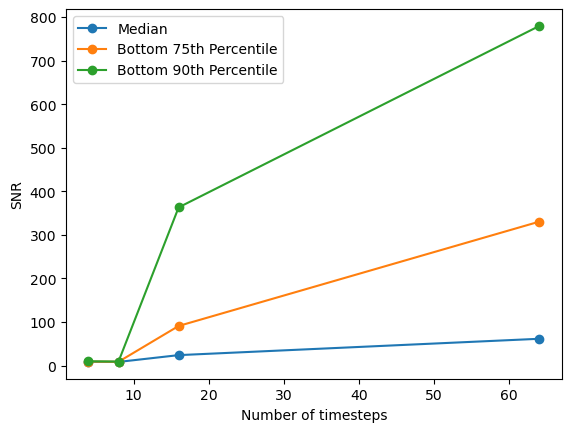

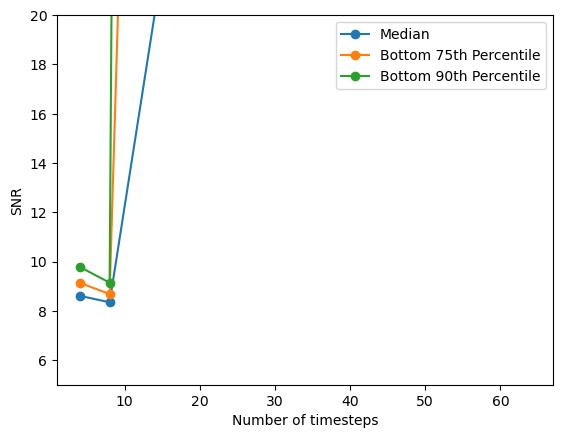

In [ ]:
# Look at median snr of hits found
groups = coherent_full.groupby("num_timesteps")
num_timesteps = list(groups.groups.keys())
median_snr_of_hits_at_timestep = [group.signal_snr.median() for _, group in groups]
bottom_75 = [group.signal_snr.quantile(.75) for _, group in groups]
bottom_90 = [group.signal_snr.quantile(.90) for _, group in groups]

# mean_snr_of_hits_at_timestep = [group.signal_snr.mean() for _, group in groups]
# std_snr_of_hits_at_timestep = [group.signal_snr.std() for _, group in groups]

plt.plot(num_timesteps, median_snr_of_hits_at_timestep, marker='o', label="Median")
plt.plot(num_timesteps, bottom_75, marker='o', label="Bottom 75th Percentile")
plt.plot(num_timesteps, bottom_90, marker='o', label="Bottom 90th Percentile")

# plt.plot(num_timesteps, mean_snr_of_hits_at_timestep, marker='o', label="Mean")
# plt.plot(num_timesteps, std_snr_of_hits_at_timestep, marker='o', label="Std")

plt.xlabel("Number of timesteps")
plt.ylabel("SNR")
# plt.yscale('log')
plt.legend()
plt.show()


plt.plot(num_timesteps, median_snr_of_hits_at_timestep, marker='o', label="Median")
plt.plot(num_timesteps, bottom_75, marker='o', label="Bottom 75th Percentile")
plt.plot(num_timesteps, bottom_90, marker='o', label="Bottom 90th Percentile")

# plt.plot(num_timesteps, mean_snr_of_hits_at_timestep, marker='o', label="Mean")
# plt.plot(num_timesteps, std_snr_of_hits_at_timestep, marker='o', label="Std")

plt.xlabel("Number of timesteps")
plt.ylabel("SNR")
plt.ylim([5, 20])
plt.legend()
plt.show()

### Combined Filters for Presentation

In [49]:
sum(coherent.signal_snr > 15) / len(coherent)

0.17865643238607049

In [55]:
sum((coherent.num_timesteps >= 16) & (coherent.signal_snr > 10)) / len(coherent)

0.2026253543022173

In [61]:
# # Make Bar Chart
# source_groups = coherent.groupby("source_name")
# source_names = list(source_groups.groups.keys())

# Get new df with just hits which are results of this filter
# ids = np.load("/home/nstieg/BL-COSMIC-2024-proj/filters/filter11/run_filter_11_coherent_results.npy")
# prev_df = coherent.copy()
# ids_in_both = list(set(prev_df.id).intersection(ids))
# prev_df = prev_df.set_index('id')
# next_df = prev_df.loc[ids_in_both].reset_index()
# n_source_groups = next_df.groupby('source_name')
# group_sizes = []
# for name, group in n_source_groups:
#     group_sizes.append(len(group))

# print(len(next_df) / len(coherent) * 100)
# print(100 - (len(next_df) / len(coherent) * 100))

# # Make Bar Chart
coherent = pd.read_pickle("/datax/scratch/nstieg/25GHz_higher_coherent_all_columns.pkl")
source_groups = coherent.groupby("source_name")
source_names = list(source_groups.groups.keys())

next_df = after_filter_dfs[-1]
groups = next_df.groupby('source_name')
n_source_groups = []
for name in source_names:
    try:
        n_source_groups.append(groups.get_group(name))
    except:
        n_source_groups.append([])

group_sizes = []
for group in n_source_groups:
    group_sizes.append(len(group))

print(len(next_df) / len(coherent) * 100)
print(100 - (len(next_df) / len(coherent) * 100))

0.01614881028163257
99.98385118971837


In [63]:
len(next_df)

482

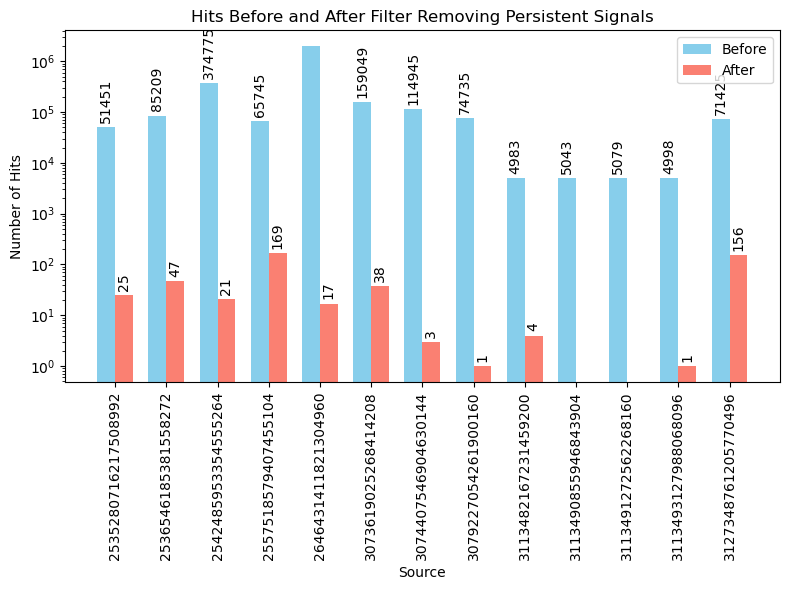

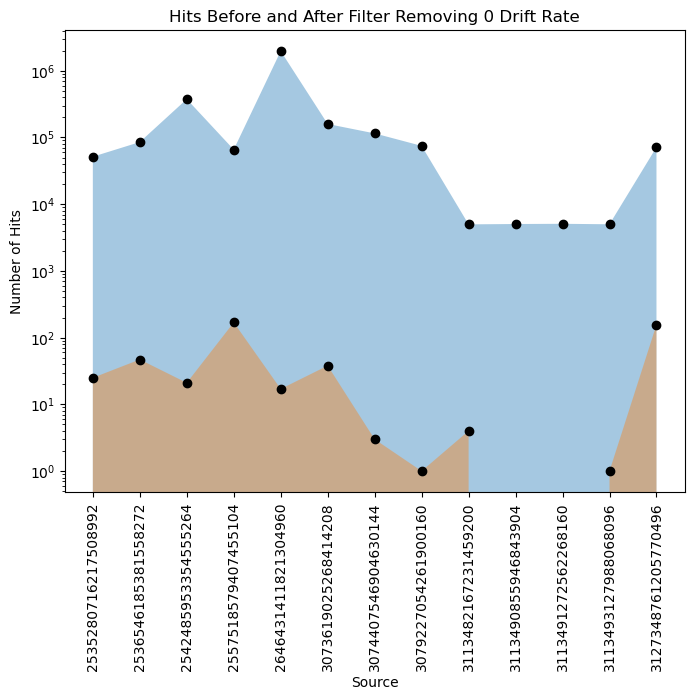

In [62]:

# c_no_zero = coherent[coherent.signal_drift_rate != 0]
# c_source_groups = c_no_zero.groupby("source_name")
# c_groups_sizes = []
# for name, group in c_source_groups:
#     c_groups_sizes.append(len(group))

# print(len(c_no_zero) / len(coherent) * 100)
# print(100 - (len(c_no_zero) / len(coherent) * 100))


x = np.arange(len(source_names))  # the label locations
width = 0.35  # the width of the bars

# Plotting the data
fig, ax = plt.subplots(figsize=(8, 6))

# Bar for "Before"
rects1 = ax.bar(x - width/2, after_filter_source_sizes[0], width, label='Before', color='skyblue')

# Bar for "After"
rects2 = ax.bar(x + width/2, group_sizes, width, label='After', color='salmon')

# Adding labels, title, and legend
ax.set_xlabel('Source')
ax.set_ylabel('Number of Hits')
ax.set_title(f'Hits Before and After Filter Removing Persistent Signals')
ax.set_xticks(x)
ax.set_xticklabels(source_names, rotation=90)
ax.legend()

# Adding value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        if height < 1e6:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

add_labels(rects1)
add_labels(rects2)

# Display the plot
plt.yscale('log')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plt.fill_between(x, after_filter_source_sizes[0], alpha=0.4)
plt.scatter(x, after_filter_source_sizes[0], marker='o', color='black')
plt.fill_between(x, group_sizes, alpha=0.4)
plt.scatter(x, group_sizes, marker='o', color='black')
ax.set_xlabel('Source')
ax.set_ylabel('Number of Hits')
ax.set_title(f'Hits Before and After Filter Removing 0 Drift Rate')
ax.set_xticks(x)
ax.set_xticklabels(source_names, rotation=90)
plt.yscale('log')
plt.show()